# Course 2 - Task 3: Build & Evaluate Models - Credit Credit Default
## Random Forest Regression Model

Author: Jason Rodriguez

## Note: 
This notebook picks up after the EDA process (different notebook). The first task and separate notebook focus on the initial preparation and exploration of the data to make inferences. This notebook will focus on ***Building & Evaluating Models specifically the RANDOM FOREST REGRESSION MODEL***


## Course Objectives
1. Given we successfully explored the data, the objective for this task is to build and evaluate various predictive models. 


## Business Problems
1. Credit One is experiencing an ***increase*** in customer defaults which ultimtely can lead to lost in clients and business
2. Credit One does not have an reliable method for identifying which customer may default and how to predict credit balance. 

## Business Goals
1. Credit One seeking solution to ***predict the right amount of credit*** to extend to customers so it does not over extend themselves and reduce risks with customers defaulting. 

## Purpose of Remaining Sections
The following sections are broken into sections that step through the process of understanding and making inferences of the available Credit One data.  The sections are as follows
1. Setting Up the Environment
2. PreProcessing & Model Preparation
3. Regression Model - *Default Params & All Features*
4. Regression Model - *Tuned Params & All Features*
5. Regression Model - *Default Params & Feature Selection*
6. Regression Model - *Tuned Params & Feature Selection*
7. Performance Comparison

***
# 1.0 - Setting Up The Environment
***

## 1.1 - Importing Libraries

In [26]:
#IMPORTING LIBRARIES
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab as pylab
from math import sqrt

#Set Default MatPlot Figure Size
pylab.rcParams['figure.figsize']=(10.0,8.0)

from sklearn import preprocessing

In [50]:
#SKLearn Components
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

#Estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn import linear_model

#Model Metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score

#Cross Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

## 1.2 - Data Load

In [28]:
#Read Data Source File
#Note: pulling revised dataset after EDA and initial preprocessing. 
credit = pd.read_csv("/Users/JasonRodriguez/Documents/UT-Data-Analytics-Program/2020-Cohort/C2-T3/Source-Data/ProcessedCreditOneData.csv")

In [29]:
credit.columns

Index(['Unnamed: 0', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Default_Status',
       'AGE_BIN2', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'MARRIAGE_Divorced', 'MARRIAGE_Married', 'MARRIAGE_Others',
       'MARRIAGE_Single'],
      dtype='object')

***
# 2.0 - Preprocessing & Model Preparation
***

## 2.1 - Preprocessing

In [30]:
#Dropping un-needed features for regression modeling
credit = credit.drop(['AGE_BIN2', 'Unnamed: 0'], axis=1)
credit.info() #confirming features and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   LIMIT_BAL          29965 non-null  int64
 1   SEX                29965 non-null  int64
 2   AGE                29965 non-null  int64
 3   PAY_1              29965 non-null  int64
 4   PAY_2              29965 non-null  int64
 5   PAY_3              29965 non-null  int64
 6   PAY_4              29965 non-null  int64
 7   PAY_5              29965 non-null  int64
 8   PAY_6              29965 non-null  int64
 9   BILL_AMT1          29965 non-null  int64
 10  BILL_AMT2          29965 non-null  int64
 11  BILL_AMT3          29965 non-null  int64
 12  BILL_AMT4          29965 non-null  int64
 13  BILL_AMT5          29965 non-null  int64
 14  BILL_AMT6          29965 non-null  int64
 15  PAY_AMT1           29965 non-null  int64
 16  PAY_AMT2           29965 non-null  int64
 17  PAY_AMT3    

## 2.2 - Filter Method using Pearson's Correlation Method

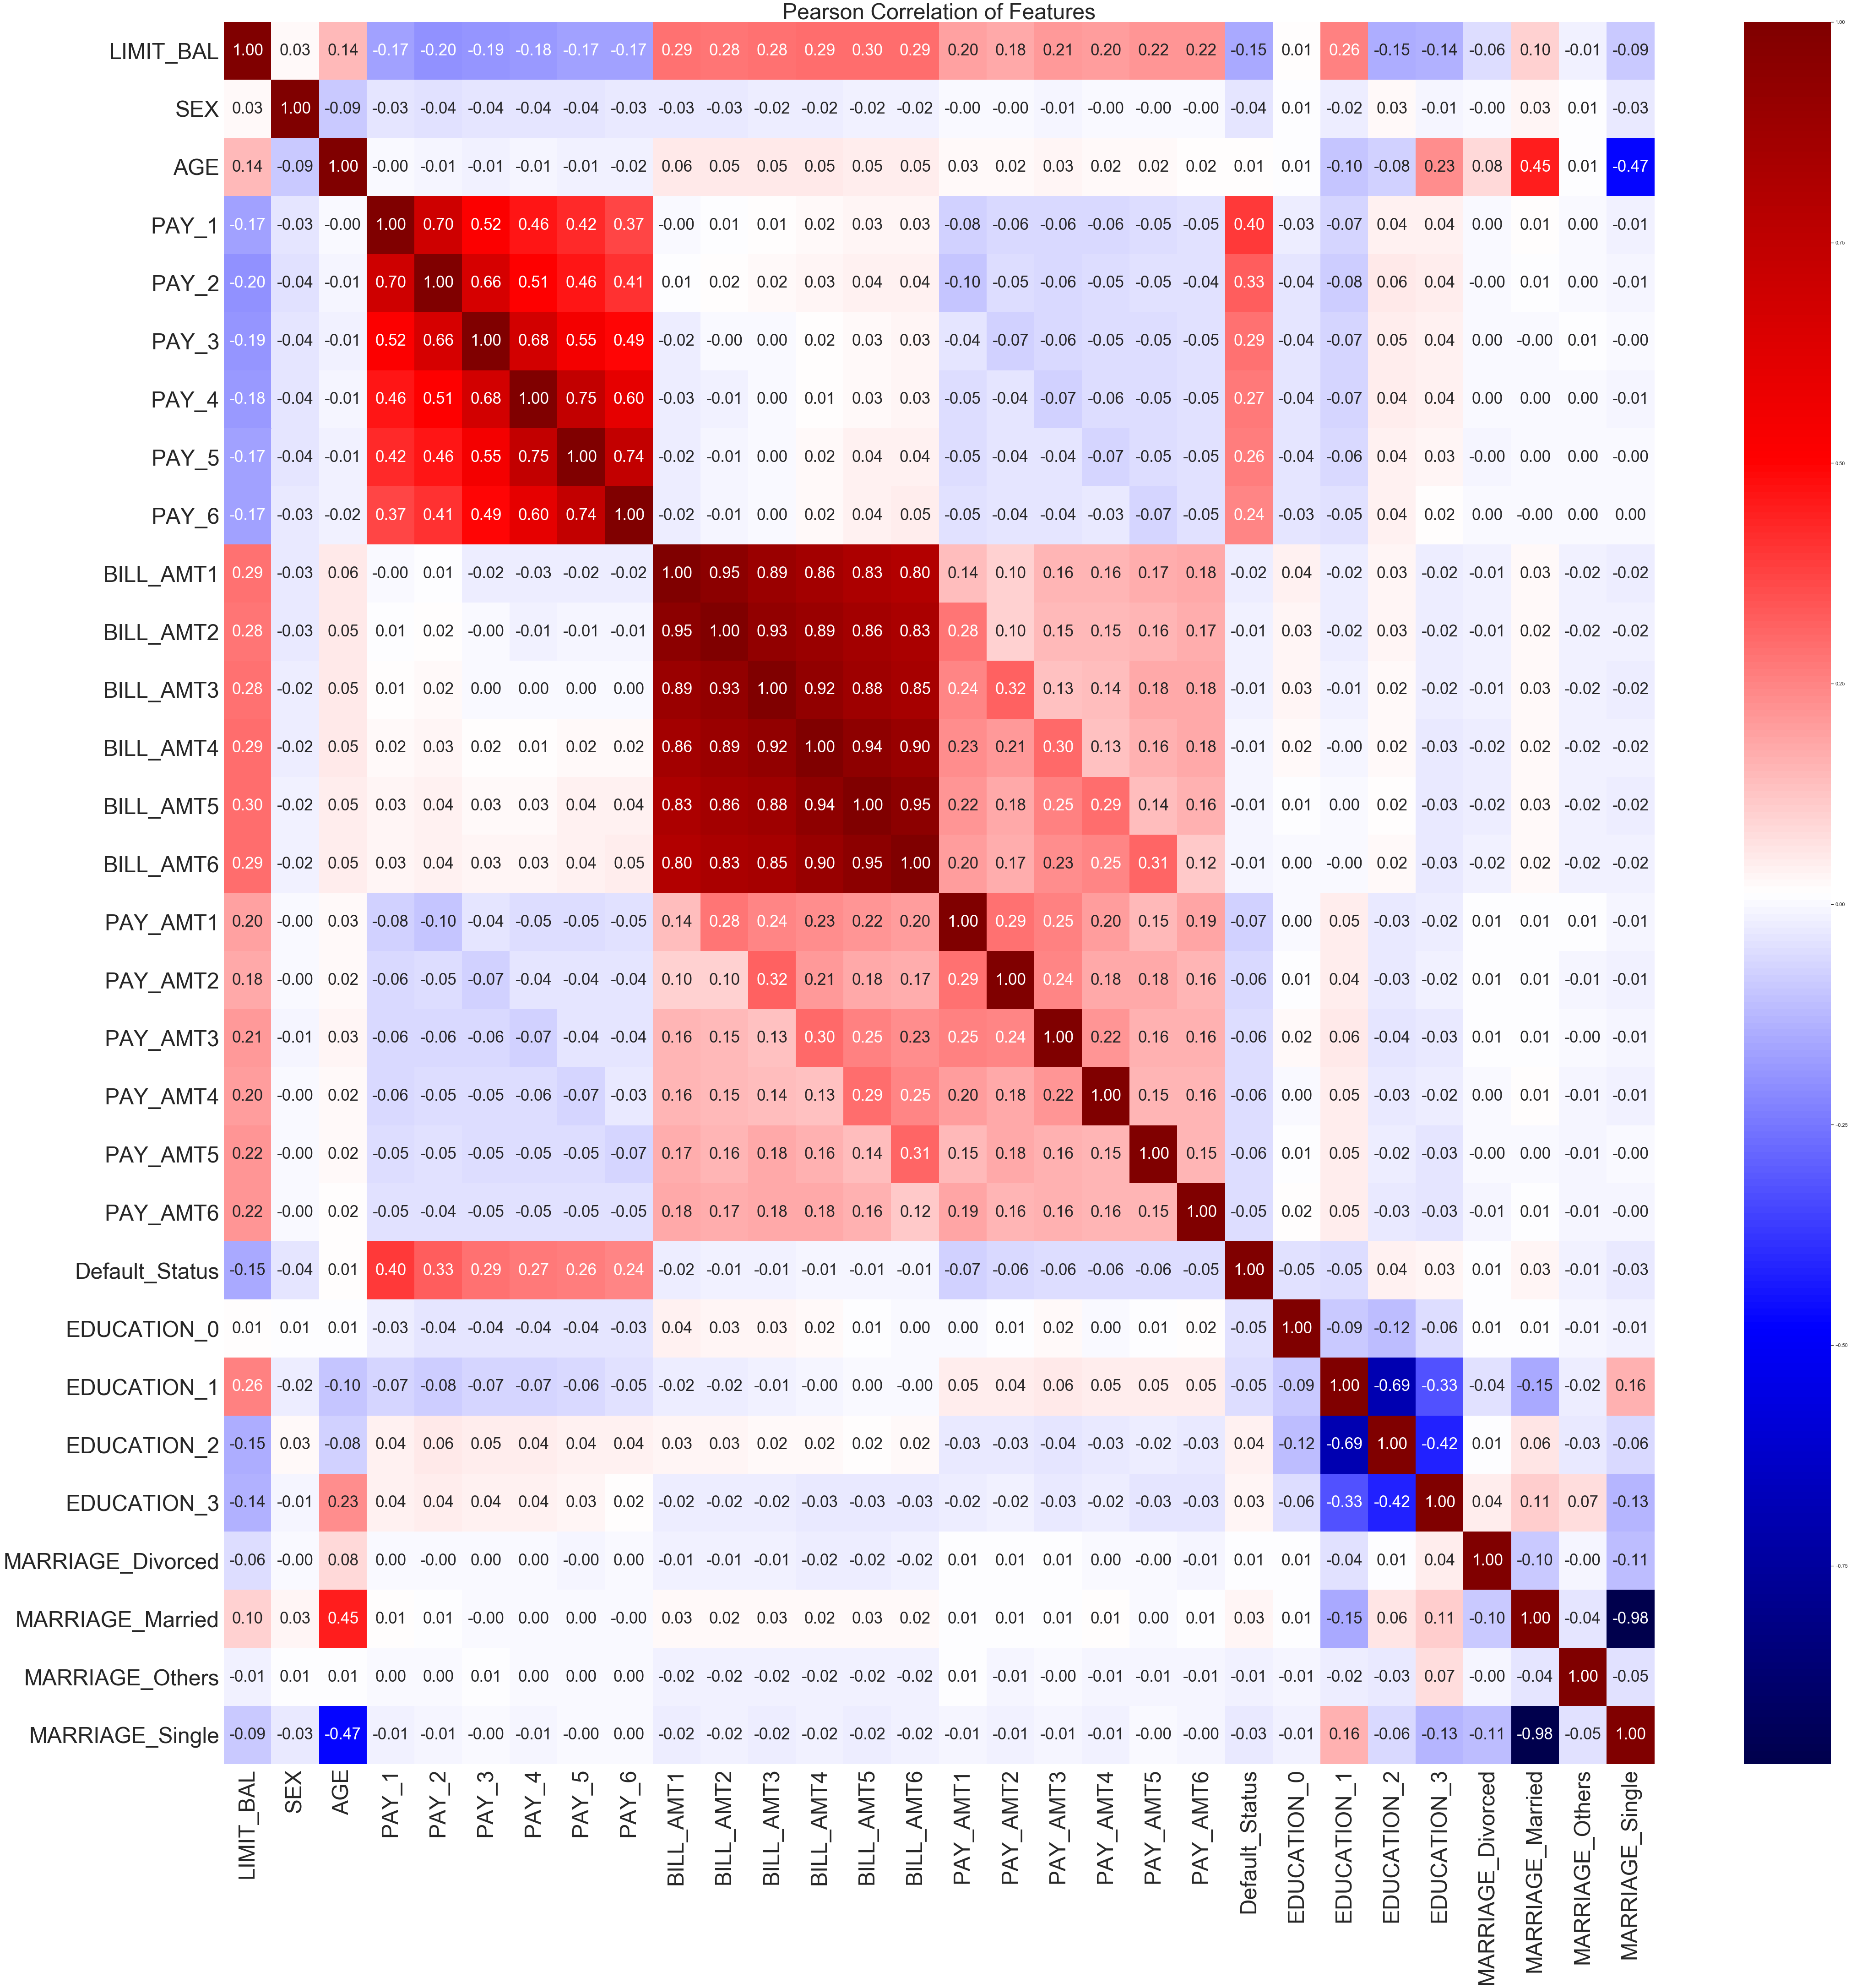

In [31]:
#Visualizing Correlation of data using Pairwise Correlation

# Configure x and y axis
corrMat=credit.corr(method='pearson')
sns.set()
plt.figure(figsize=(70,70))
plt.xticks(fontsize=48)
plt.yticks(fontsize=48)
plt.title('Pearson Correlation of Features', size =48)

# Plotting the data using heatmap
g = sns.heatmap(corrMat,annot=True,cmap="seismic",annot_kws={"size": 35},fmt=".2f")

**OBSERVATION:**
1. Payment Status (PAY0-Pay6) is highly correlated to each other
2. Bill Amount (Bill_Amt1-Bill_Amt6) is highly correlated to each other
3. Default Status have strong correlation to Payment status
4. Pay1-6, Default Status, Education_1-3, and Marriage_Single have low or negative correlation to LIMIT_Bal (target var)

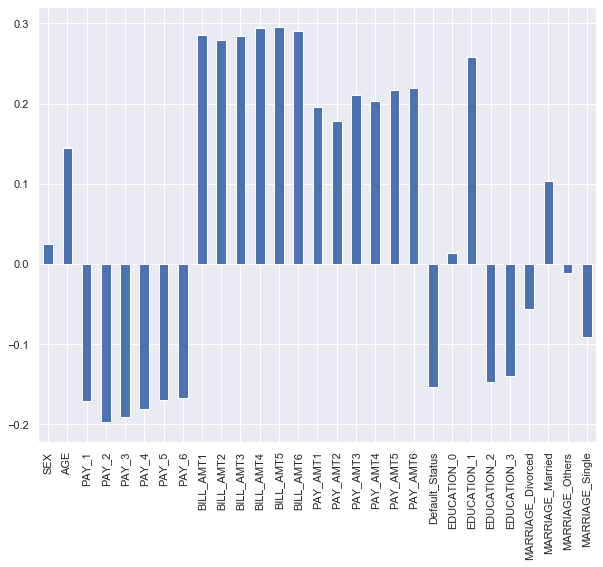

In [32]:
#Visual of Correlation
Limit_bal_corr = corrMat.iloc[0,1:]
Limit_bal_corr.plot(kind='bar',figsize=(10,8))
#confirming observations above. 

**Observation:***
1. Bill_Amt 1-6; Pay_Amt 1-6 and Education_1 (followed by age & Marriage_Married) are the best features based on Filter Feature Selection Method

## 2.3 - Preparing Models

In [33]:
#Selecting Features for Independent Variables 
X=credit.iloc[:,1:]
print('Summary of feature sample')
X.head()

Summary of feature sample


,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT6,Default_Status,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,MARRIAGE_Divorced,MARRIAGE_Married,MARRIAGE_Others,MARRIAGE_Single
0,1,24,2,2,0,0,0,0,3913,3102,...,0,1,0,0,1,0,0,1,0,0
1,1,26,0,2,0,0,0,2,2682,1725,...,2000,1,0,0,1,0,0,0,0,1
2,1,34,0,0,0,0,0,0,29239,14027,...,5000,0,0,0,1,0,0,0,0,1
3,1,37,0,0,0,0,0,0,46990,48233,...,1000,0,0,0,1,0,0,1,0,0
4,0,57,0,0,0,0,0,0,8617,5670,...,679,0,0,0,1,0,0,1,0,0


In [40]:
#Selecting features for Dependent Variable
y=credit['LIMIT_BAL']
print('Summary of dependent variable')
y.head()

Summary of dependent variable


0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [41]:
#Splitting Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 123)

***
# 3.0 - Randon Forest - *Default Params & All Features*
***

#### Cross Validation

In [44]:
#Random Forest Model with Default Params
RF_default = RandomForestRegressor()

#Cross Validation
cross_val_score_RF_default = cross_val_score(RF_default, X, y, cv=5, scoring='r2')
print('Cross_Val_Score for RF: ', cross_val_score_RF_default.mean())

Cross_Val_Score for RF:  0.4666407035761452


#### Train Model

In [45]:
RF_default.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Predicting Test Data

In [46]:
predRF_default = RF_default.predict(X_test)

#### Performance Metrics

In [49]:
#Prediction Evaluation Results
predRSquared_RF_default = r2_score(y_test,predRF_default)
print('R-Squared Prediction Score for RF: %.3f' % predRSquared_RF_default)

#Mean Square Error
rmse_RF_default = sqrt(mean_squared_error(y_test,predRF_default))
print('RMSE Prediction Score for RF: %.3f' % rmse_RF_default)

R-Squared Prediction Score for RF: 0.471
RMSE Prediction Score for RF: 94219.410


***OBSERVATION:***

R2 of Defaulted RF Algorithm is **0.471**

***
# 4.0 - Randon Forest - *Tuning HyperParameters & All Features*
***

#### Creating Parameters Grid

In [56]:
#Parameter Setting 
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]

max_features = ['auto','sqrt']

max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=20)]
max_depth.append(None)

min_samples_split = [2,5,10,20]

min_samples_leaf = [1, 2, 5, 10]

bootstrap = [True, False]

#Create Random Grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 24, 28, 33, 38, 43, 47, 52, 57, 62, 66, 71, 76, 81, 85, 90, 95, 100, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}


#### Random Search for Best Hyperparameters

In [57]:
#Using Random Grid to Search for Best Hyperparameters
#Create Base Model
RF_Params = RandomForestRegressor()

#Random Search of Params - using 3 Cross Validation; seach across 50 combinations; use all available cores
rf_random = RandomizedSearchCV(estimator=RF_Params, param_distributions = random_grid, n_iter=50, cv=3, n_jobs=-1)

#Fit Random Search Model
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [58]:
#Print Best Params Results
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 71,
 'bootstrap': False}

#### Train & Test on NEW HYPERPARAMS

In [67]:
rf_TUNED = RandomForestRegressor(n_estimators=400,
                                min_samples_split=20,
                                min_samples_leaf=2,
                                max_depth=71,
                                bootstrap=True)
rf_TUNED.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=71, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Predict Model

In [68]:
pred_rf_tuned = rf_TUNED.predict(X_test)

#### Performance Results

In [69]:
#Prediction Evaluation Results
predRSquared_RF_tuned= r2_score(y_test,pred_rf_tuned)
print('R-Squared Prediction Score for RF: %.3f' % predRSquared_RF_tuned)

#Mean Square Error
rmse_RF_tuned = sqrt(mean_squared_error(y_test,pred_rf_tuned))
print('RMSE Prediction Score for RF: %.3f' % rmse_RF_tuned)

R-Squared Prediction Score for RF: 0.483
RMSE Prediction Score for RF: 93115.731


***OBSERVATION:***

R2 of Tuned RF Algorithm is **0.483**; very slight improvement against default algorithm

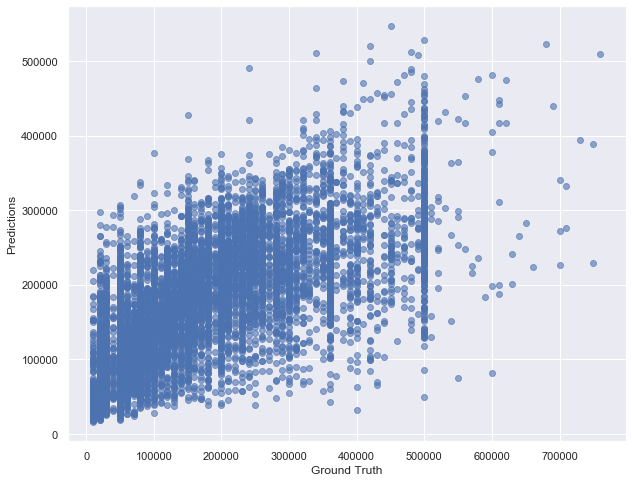

In [71]:
plt.scatter(y_test, pred_rf_tuned, alpha=0.6)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show()

***
# 5.0 - Randon Forest - *Default Params & Feature Selection*
***

In [74]:
#Selecting best correlated features from above
X = credit[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6', 'PAY_AMT1','PAY_AMT2',
           'PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','AGE', 'EDUCATION_1', 'MARRIAGE_Married']]

y = credit['LIMIT_BAL']

In [75]:
#Splitting Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 123)

#### Cross Validation

In [80]:
#Random Forest Model with Tuned Params & Feature Selection
RF_default_featSel = RandomForestRegressor()

#Cross Validation
cross_val_score_RF_default_FeatSel = cross_val_score(RF_default_featSel, X, y, cv=5, scoring='r2')
print('Cross_Val_Score for RF: ', cross_val_score_RF_default_FeatSel.mean())

Cross_Val_Score for RF:  0.46014147595711224


In [81]:
#Train Model
RF_default_featSel.fit(X_train,y_train)

#Prediction
predRF_default_featSel = RF_default_featSel.predict(X_test)

#Prediction Evaluation Results
predRSquared_RF_default_featSel = r2_score(y_test,predRF_default_featSel)
print('R-Squared Prediction Score for RF: %.3f' % predRSquared_RF_default_featSel)

#Mean Square Error
rmse_RF_default_featSel = sqrt(mean_squared_error(y_test,predRF_default_featSel))
print('RMSE Prediction Score for RF: %.3f' % rmse_RF_default_featSel)

R-Squared Prediction Score for RF: 0.461
RMSE Prediction Score for RF: 95120.047


OBSERVATION:
R2 of Tuned RF Algorithm w/ Feature Selection is **0.461**

***
# 6.0 - Random Forest - *Tuning Params & Feature Selection*
***

#### Creating Parameters Grid

In [83]:
#Parameter Setting 
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]

max_features = ['auto','sqrt']

max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=20)]
max_depth.append(None)

min_samples_split = [2,5,10,20]

min_samples_leaf = [1, 2, 5, 10]

bootstrap = [True, False]

#Create Random Grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 24, 28, 33, 38, 43, 47, 52, 57, 62, 66, 71, 76, 81, 85, 90, 95, 100, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}


#### Random Search for Best Hyperparameters

In [84]:
#Using Random Grid to Search for Best Hyperparameters
#Create Base Model
RF_Params = RandomForestRegressor()

#Random Search of Params - using 3 Cross Validation; seach across 50 combinations; use all available cores
rf_random = RandomizedSearchCV(estimator=RF_Params, param_distributions = random_grid, n_iter=50, cv=3, n_jobs=-1)

#Fit Random Search Model
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [85]:
#Print Best Params Results
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 66,
 'bootstrap': False}

#### Train & Test on NEW HYPERPARAMS


In [86]:
rf_tuned_featSel = RandomForestRegressor(n_estimators=400,
                                min_samples_split=2,
                                min_samples_leaf=5,
                                max_depth=66,
                                bootstrap=True)
rf_tuned_featSel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=66, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Predict and Performance Results

In [87]:
#Predict Model
pred_rf_tuned_featSel = rf_tuned_featSel.predict(X_test)

#Prediction Evaluation Results
predRSquared_RF_tuned_featSel= r2_score(y_test,pred_rf_tuned_featSel)
print('R-Squared Prediction Score for RF: %.3f' % predRSquared_RF_tuned_featSel)

#Mean Square Error
rmse_RF_tuned_featSel = sqrt(mean_squared_error(y_test,pred_rf_tuned_featSel))
print('RMSE Prediction Score for RF: %.3f' % rmse_RF_tuned_featSel)


R-Squared Prediction Score for RF: 0.475
RMSE Prediction Score for RF: 93855.637


***OBSERVATION:***

R2 of Tuned RF Algorithm w/ Feature Selection is **0.475**; very slight decrease against tuned algorithm w/ all features

***
# 7.0 - Comparison of Performance Results
***

In [88]:
print('R-Squared Performance for Random Forest Regression')
print('R-Squared for RF Default Params & All Features: ', predRSquared_RF_default)
print('R-Squared for RF Tuned Params & All Features: ', predRSquared_RF_tuned)
print('R-Squared for RF Default Params & Feature Selection: ', predRSquared_RF_default_featSel)
print('R-Squared for RF Tuned Params & Feature Selection: ', predRSquared_RF_tuned_featSel)


R-Squared Performance for Random Forest Regression
R-Squared for RF Default Params & All Features:  0.47086054887647066
R-Squared for RF Tuned Params & All Features:  0.4831845381164436
R-Squared for RF Default Params & Feature Selection:  0.46069618345453
R-Squared for RF Tuned Params & Feature Selection:  0.4749385890627036


### Summary

Best performance but yet unspectacular improvement is ***Random Forest Regression Model with Tuned Hyperparameters using ALL features at 48.3%***